In [1]:
import os
import multiprocessing
from functools import partial
from tqdm import tqdm_notebook as tqdm
import numpy as np
from scipy.ndimage import label
from skimage.transform import integral_image
from skimage.feature import haar_like_feature, hessian_matrix, hessian_matrix_eigvals
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt
from phathom import io
from phathom.segmentation.segmentation import find_centroids
from phathom.utils import pmap_chunks, extract_box, insert_box

In [2]:
working_dir = '/media/jswaney/Drive/Justin/coregistration/gabi_pv'

In [3]:
pv_path = 'pvtdtomato_zarrstack/1_1_1'

pv_img = io.zarr.open(os.path.join(working_dir, pv_path))

pv_img.shape

(256, 7275, 5529)

In [4]:
img = pv_img[0]

<IPython.core.display.Javascript object>


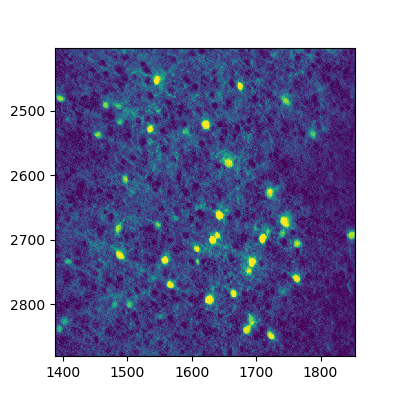

In [328]:
%matplotlib notebook
plt.figure(figsize=(4, 4))
plt.imshow(img, clim=[0, 1200])
plt.show()

In [5]:
sigma = 5.0

hessian = hessian_matrix(img, sigma)
eigvals = hessian_matrix_eigvals(hessian)

/home/jswaney/anaconda3/envs/phathom/lib/python3.6/site-packages/skimage/feature/corner.py:167: UserWarning: deprecation warning: the default order of the hessian matrix values will be "row-column" instead of "xy" starting in skimage version 0.15. Use order="rc" or order="xy" to set this explicitly
  warn('deprecation warning: the default order of the hessian matrix values '


In [6]:
eigvals = np.clip(eigvals, None, 0)  # remove positive curvatures

In [7]:
threshold = -threshold_otsu(-eigvals[0])  # Based on larger eigenvalue

In [8]:
loc = np.where(eigvals[0] < threshold)

In [9]:
mask = np.zeros(img.shape, np.int)
mask[loc] = 1

In [10]:
lbl, nb_lbls = label(mask)
nb_lbls

4738

In [11]:
centroids = find_centroids(lbl[np.newaxis])[:, 1:3]
centroids[:5]

array([[ 633.86206897, 1997.67816092],
       [ 640.92647059, 2080.32352941],
       [ 651.76190476, 2065.        ],
       [ 666.06930693, 2270.68316832],
       [ 674.904     , 2231.36      ]])

In [277]:
width = 31
patches = np.zeros((nb_lbls, width, width), img.dtype)
for i, (y, x) in enumerate(centroids):
    y, x = int(round(y)), int(round(x))
    start = [y - width // 2, x - width // 2]
    stop = [y + width // 2 + 1, x + width // 2 + 1]
    patches[i] = img[start[0]:stop[0], start[1]:stop[1]]

<IPython.core.display.Javascript object>


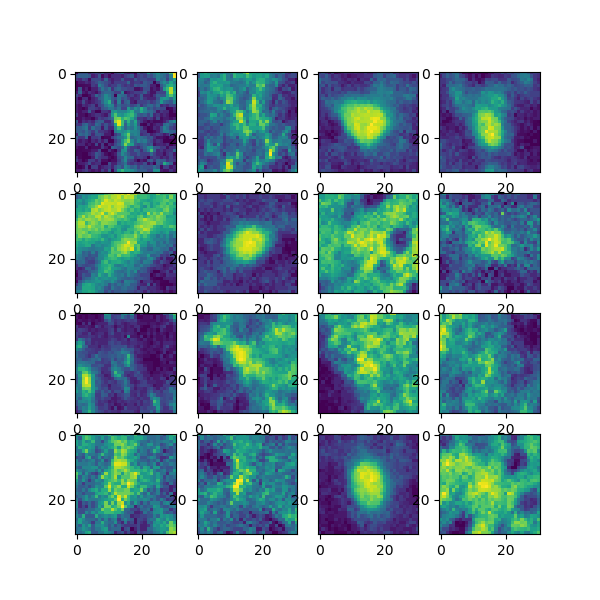

In [338]:
plt.figure(figsize=(6, 6))
for i, s in enumerate(np.random.choice(np.arange(nb_lbls), 16, replace=False)):
    plt.subplot(4, 4, i+1)
    plt.imshow(patches[s])
plt.show()

# InceptionV3

In [14]:
import keras
from keras.applications.inception_v3 import InceptionV3, preprocess_input

Using TensorFlow backend.


In [17]:
help(preprocess_input)

Help on function preprocess_input in module keras_applications.inception_v3:

preprocess_input(x)
    Preprocesses a numpy array encoding a batch of images.
    
    # Arguments
        x: a 4D numpy array consists of RGB values within [0, 255].
    
    # Returns
        Preprocessed array.



In [36]:
from skimage.transform import resize

def gray_to_rgb(img):
    img = resize(img, (299, 299))
    img_rgb = np.zeros((*img.shape, 3), np.uint8)
    img_rgb[..., 0] = (img / img.max() * 255).astype(np.uint8)
    img_rgb[..., 1] = (img / img.max() * 255).astype(np.uint8)
    img_rgb[..., 2] = (img / img.max() * 255).astype(np.uint8)
    return img_rgb

In [279]:
patches_rgb = np.zeros((nb_lbls, 299, 299, 3), np.uint8)
for i, patch in enumerate(patches):
    patches_rgb[i] = gray_to_rgb(patch)
patches_rgb.shape, patches_rgb.max()

/home/jswaney/anaconda3/envs/phathom/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/jswaney/anaconda3/envs/phathom/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


((4738, 299, 299, 3), 255)

In [17]:
base_model = InceptionV3(weights='imagenet', include_top=False)

In [280]:
X = preprocess_input(patches_rgb)

In [281]:
output = base_model.predict(X)

In [282]:
aves = output.mean(axis=(1, 2))
stds = output.std(axis=(1, 2))

In [287]:
mfi = X.mean(axis=(1, 2, 3))
sdfi = X.std(axis=(1, 2, 3))
mfi_center = X[:, width//4:width*3//4, width//4:width*3//4, :].mean(axis=(1, 2, 3))

In [288]:
features = np.concatenate((aves, stds, mfi[:, np.newaxis], sdfi[:, np.newaxis], mfi_center[:, np.newaxis]), axis=-1)
features.shape

(4738, 4099)

In [289]:
output.shape, features.shape

((4738, 8, 8, 2048), (4738, 4099))

In [206]:
from sklearn.decomposition import PCA
# from sklearn.cluster import FeatureAgglomeration  # worked okay too

In [290]:
X_pca = PCA(n_components=8).fit_transform(features)
X_pca.shape

(4738, 8)

<IPython.core.display.Javascript object>


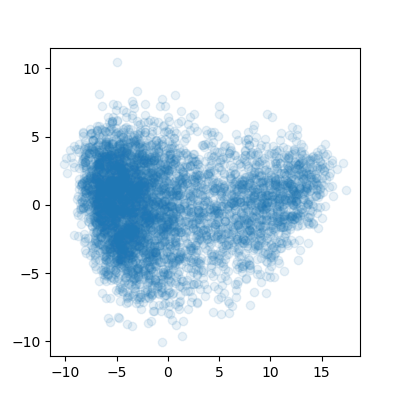

In [314]:
plt.figure(figsize=(4, 4))
plt.scatter(X_pca[:, 0], X_pca[:, 3], alpha=0.1)
plt.show()

In [128]:
from sklearn.manifold import TSNE

In [226]:
X_tsne = TSNE(n_components=2, learning_rate=1000).fit_transform(X_pca)
X_tsne.shape

(4738, 2)

<IPython.core.display.Javascript object>


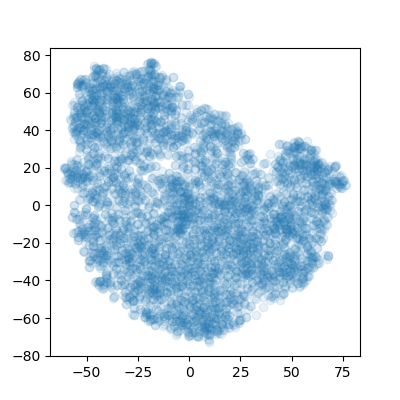

In [227]:
plt.figure(figsize=(4, 4))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.1)
plt.show()

In [61]:
from sklearn.mixture import GaussianMixture

In [315]:
n_components = 2

gmm = GaussianMixture(n_components=n_components).fit(X_pca)

In [316]:
labels = gmm.predict(X_pca)

In [317]:
c = []
for i in range(n_components):
    c.append(X_pca[np.where(labels==i)[0]])

<IPython.core.display.Javascript object>


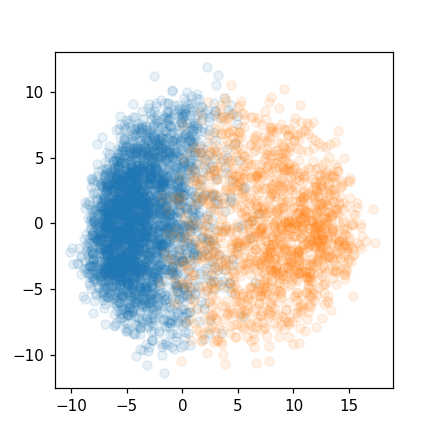

In [356]:
plt.figure(figsize=(4,4))
for i in range(n_components):
    plt.scatter(c[i][:, 0], c[i][:, 1], alpha=0.1)
plt.show()

In [321]:
patches0 = patches[np.where(labels==0)[0]]
patches1 = patches[np.where(labels==1)[0]]

In [322]:
patches0.shape, patches1.shape

((3270, 31, 31), (1468, 31, 31))

<IPython.core.display.Javascript object>


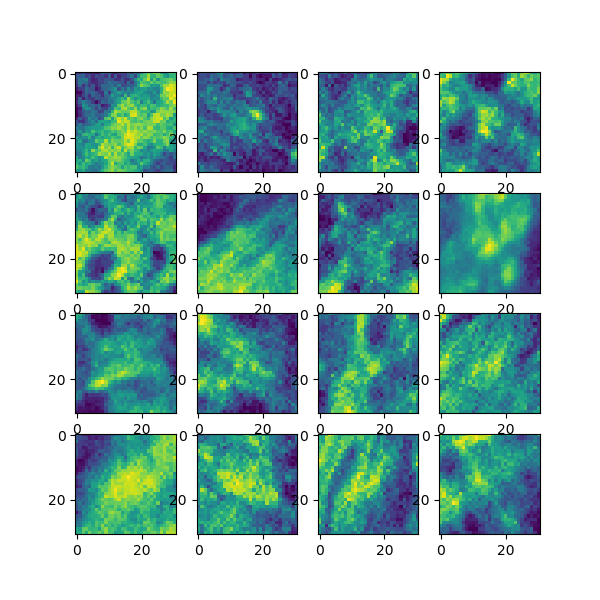

In [334]:
plt.figure(figsize=(6, 6))
for i, s in enumerate(np.random.choice(np.arange(len(patches0)), 16, replace=False)):
    plt.subplot(4, 4, i+1)
    plt.imshow(patches0[s])
plt.show()

<IPython.core.display.Javascript object>


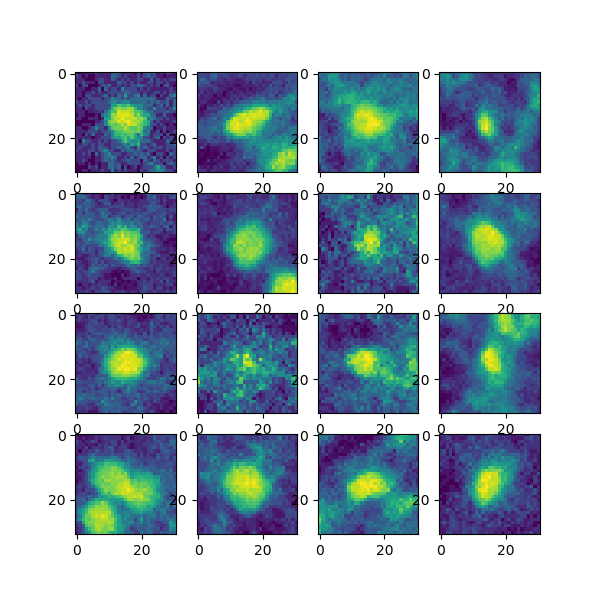

In [336]:
plt.figure(figsize=(6, 6))
for i, s in enumerate(np.random.choice(np.arange(len(patches1)), 16, replace=False)):
    plt.subplot(4, 4, i+1)
    plt.imshow(patches1[s])
plt.show()

# Nucleus and PV colocalization

In [339]:
syto_path = 'syto16_zarrstack/1_1_1'

syto_img = io.zarr.open(os.path.join(working_dir, syto_path))
syto_slice = syto_img[0]

In [341]:
pv_slice = img

In [348]:
sigma = 4.0

pv_hessian = hessian_matrix(pv_slice, sigma)
pv_eigvals = hessian_matrix_eigvals(pv_hessian)

/home/jswaney/anaconda3/envs/phathom/lib/python3.6/site-packages/skimage/feature/corner.py:167: UserWarning: deprecation warning: the default order of the hessian matrix values will be "row-column" instead of "xy" starting in skimage version 0.15. Use order="rc" or order="xy" to set this explicitly
  warn('deprecation warning: the default order of the hessian matrix values '


In [349]:
syto_hessian = hessian_matrix(syto_slice, sigma)
syto_eigvals = hessian_matrix_eigvals(syto_hessian)

/home/jswaney/anaconda3/envs/phathom/lib/python3.6/site-packages/skimage/feature/corner.py:167: UserWarning: deprecation warning: the default order of the hessian matrix values will be "row-column" instead of "xy" starting in skimage version 0.15. Use order="rc" or order="xy" to set this explicitly
  warn('deprecation warning: the default order of the hessian matrix values '


In [350]:
pv_eigvals = np.clip(pv_eigvals, None, 0)
syto_eigvals = np.clip(syto_eigvals, None, 0)

In [351]:
pv_thresh = -threshold_otsu(-pv_eigvals[0])  # Based on larger eigenvalue
syto_thresh = -threshold_otsu(-syto_eigvals[0])

pv_thresh, syto_thresh

(-4.3798543836885535e-05, -0.00016368934533315743)

In [352]:
loc = np.where(pv_eigvals[0] < pv_thresh)
pv_mask = np.zeros(pv_slice.shape, np.int)
pv_mask[loc] = 1

In [353]:
loc = np.where(syto_eigvals[0] < syto_thresh)
syto_mask = np.zeros(syto_slice.shape, np.int)
syto_mask[loc] = 1

In [358]:
mask = pv_mask * syto_mask

<IPython.core.display.Javascript object>


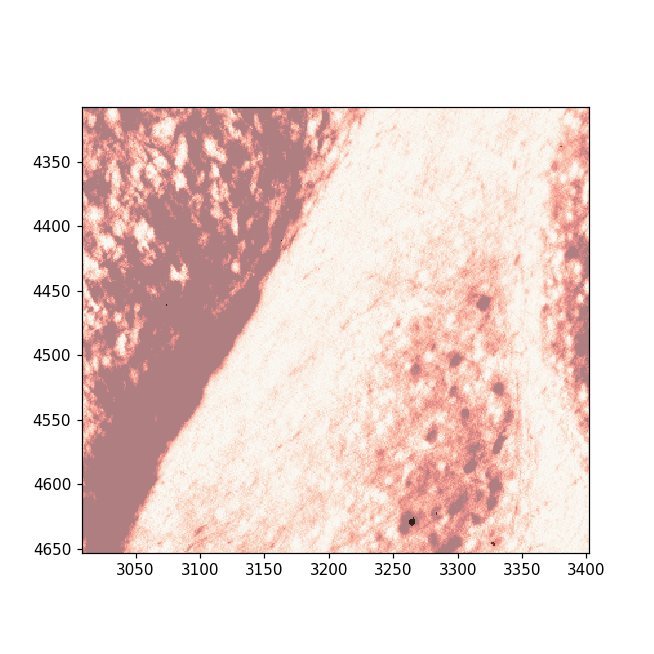

In [365]:
plt.figure(figsize=(6,6))
plt.imshow(mask, cmap='Greens')
plt.imshow(pv_slice, cmap='Reds', clim=[0, 1200], alpha=0.5)
plt.show()